# Source Location Identification for Helmholtz

**The Equation** $$ \begin{cases} \Delta u + k^2 u = -f & x\in\Omega \\ \nabla u \cdot n = g & x \in \Gamma \end{cases}$$
Take $k=1.0$, $g = 0$, and $\Omega = (0,1)^2$.  Define the source $f$ as $$ f(x) = \exp\{-10(\|x-x_0\|_2^2+\|x-x_1\|_2^2)\},$$ where $x_0$ and $x_1$ are unknown locations in $\Omega$.  We will generate synthetic data based on true parameters $x_0=(0.15,0.15)$ and $x_1 = (0.15,0.85)$.  Perturb the data with some Gaussian noise and invert for $x_0$ and $x_1$ using MUQ tools.

Imports

In [1]:
from __future__ import print_function, absolute_import, division

# Import FEniCS
import dolfin as dl
import math
import numpy as np

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
import pymuqModeling as mm

from hippylib import nb

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

Finite element mesh and spaces

In [2]:
n = 128
d = 1
mesh = dl.UnitSquareMesh(n, n)
Vh = dl.FunctionSpace(mesh, "Lagrange", d)

Define everything for FEniCS up to the source $f$.

In [3]:
uh = dl.TrialFunction(Vh)
vh = dl.TestFunction(Vh)
g = dl.Constant(0.)
k = dl.interpolate(dl.Expression("1.0",degree=2), Vh)
a = (dl.inner(dl.grad(uh), dl.grad(vh))+dl.inner(k*uh,vh))*dl.dx

Create a child of dolfin.Expression to define the source function $f$.  
This allows for more efficient computation of $f$ when we alter $x_0$ and $x_1$.

In [4]:
class SourceExpression(dl.Expression):
    def __init__(self, srclocs, **kwargs):
        self.srclocs = srclocs

    def eval(self, values, x):
        logval = 0
        for i in range(2):
            for j in range(2):
                logval += -10*(x[i]-self.srclocs[i,j])*(x[i]-self.srclocs[i,j])
        values[0] = np.exp(logval)
    def value_shape(self):
        return (1,)

Define the rest of the problem for FEniCS, using the true parameters.  Solve the system.

In [6]:
srclocs = np.array([[0.15,0.15],[0.15,0.85]])
f = SourceExpression(srclocs = srclocs,element = Vh.ufl_element())
L = -f*vh*dl.dx+g*vh*dl.ds
A, b = dl.assemble_system(a, L)
uh = dl.Function(Vh)
dl.solve(A,uh.vector(),b)

1

Plot the true solution.

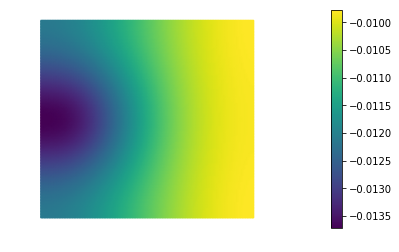

In [17]:
nb.plot(uh)

Randomly generate observation locations.

In [21]:
n_obs = 200
np.random.seed(42069)
test_locs = np.array([np.random.uniform(low=0,high=1,size=(2,)) for i in range(n_obs)])

Perturb the solution with Gaussian random noise.

In [33]:
ud = dl.Function(Vh)
ud.assign(uh)
MAX = ud.vector().norm("linf")
noise = dl.Vector()
A.init_vector(noise,1)
noise_level = 0.01
np.random.seed(24601)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
ud.vector().axpy(1., noise)

Evaluate the perturbed state at the random observation locations.  
Plot the perturbed solution and overlay the observation locations.

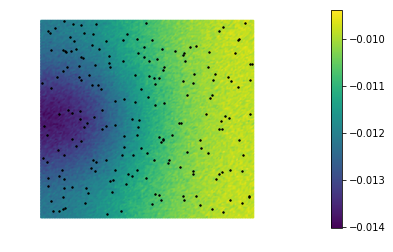

In [34]:
data = np.zeros((n_obs,))
tmp = np.zeros((1,))
for i in range(n_obs):
    ud.eval(tmp,test_locs[i,:])
    data[i] = tmp
nb.plot(ud)
ax = plt.gca()
ax.scatter(test_locs[:,0],test_locs[:,1],s=2,c='k')

Define the forward model.  EvaluateImpl takes in the source locations as a 2x2 array and outputs the solution to the Helmholtz equation at our random observation locations.

In [35]:
class ForwardHelmholtz_sourcespec(mm.PyModPiece):
    
    def __init__(self,g,k,a,uh,vh,Vh,test_locs):
        mm.PyModPiece.__init__(self, [4], 
                                     [test_locs.shape[0]]) 
        self.Vh = Vh
        self.uh = uh
        self.vh = vh
        self.g = g
        self.k = k
        self.a = a
        self.test_locs = test_locs
        
    def EvaluateImpl(self, inputs):
        m = inputs[0]
        srclocs = np.array([[m[0],m[1]],[m[2],m[3]]])
        f = SourceExpression(srclocs = srclocs,element = Vh.ufl_element())
        L = -f*vh*dl.dx + g*vh*dl.ds
        A, b = dl.assemble_system(self.a, L)
        uh = dl.Function(self.Vh)
        dl.solve(A, uh.vector(), b)
        n_locs = test_locs.shape[0]
        vals = np.zeros((1))
        statevals = np.zeros((n_locs))
        for j in range(n_locs):
            uh.eval(vals,test_locs[j,:])
            statevals[j] = vals[0]
        self.outputs = [statevals]

In [ ]:
FHss = ForwardHelmholtz_sourcespec(g,k,a,uh,vh,Vh,test_locs)

In [ ]:
PriorMu = np.array([0.15,0.15,0.15,0.85])
PriorCov = np.array([[]])
Prior = mm.Gaussian(PriorMu, PriorCov).AsDensity()